In [2]:
# first we need a bit of import boilerplate
import os
import pickle as pkl
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from pathlib import Path
import json
from IPython.display import display
from PIL import Image
from tqdm import tqdm
from neo import SpikeTrain
import quantities as pq
import warnings
from elephant.gpfa import GPFA
from sklearn.model_selection import cross_val_score

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

/var/folders/x1/kctky5lj58xftczlyf92pxcc0000gn/T/ipykernel_19572/2437169692.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = os.path.expanduser("~/ecephys/data")
resources_dir = Path.cwd().parent / 'resources'
DOWNLOAD_LFP = False

# Obtain session data

In [3]:
# Example cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [4]:
session_id = 756029989 # for example
session = cache.get_session_data(session_id)

/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [6]:
session.units.head()

/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached names

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,local_index,max_drift,nn_hit_rate,nn_miss_rate,peak_channel_id,presence_ratio,waveform_recovery_slope,waveform_repolarization_slope,silhouette_score,snr,waveform_spread,waveform_velocity_above,waveform_velocity_below,waveform_duration,filtering,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951814884,0.522713,187.434780,0.042404,6,463.86,3.555518,9.492176,0.181638,46.750473,0.024771,5,45.64,0.727333,0.016202,850126382,0.99,-0.249885,0.673650,0.033776,3.342535,40.0,0.000000,0.000000,0.151089,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,4,43,760640083,60,APN,215.0,APN,8162.0,3487.0,6737.0,probeA,See electrode locations,29999.949611,1249.9979,True
951814876,0.652514,129.686505,0.097286,5,325.21,4.445414,39.100557,0.004799,85.178750,0.001785,4,40.68,1.000000,0.003756,850126382,0.99,-0.143762,0.518633,0.108908,2.589717,50.0,0.000000,0.000000,0.315913,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,4,43,760640083,60,APN,215.0,APN,8162.0,3487.0,6737.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815032,0.484297,207.380940,0.015482,17,396.28,3.848256,28.383277,0.007099,89.608836,0.035654,15,40.01,0.986000,0.014673,850126398,0.99,-0.255492,0.766347,0.096715,3.811566,80.0,-0.206030,-0.686767,0.164824,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,12,43,760640083,140,APN,215.0,APN,8129.0,3419.0,6762.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815275,0.600600,158.158650,0.063807,30,374.82,3.065938,5.709358,0.032317,48.114336,0.016783,27,33.32,0.883598,0.003683,850126416,0.99,-0.206676,0.628944,0.144249,2.918134,60.0,0.686767,0.000000,0.178559,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,21,11,760640083,220,APN,215.0,APN,8095.0,3349.0,6787.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815314,0.459025,173.475705,0.072129,34,420.05,4.198612,23.902235,0.048075,76.916334,0.009666,31,42.80,0.968000,0.017600,850126420,0.99,-0.171503,0.740222,0.111106,3.360324,90.0,-0.068677,-0.274707,0.178559,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,23,27,760640083,240,APN,215.0,APN,8088.0,3333.0,6792.0,probeA,See electrode locations,29999.949611,1249.9979,True


# Get the right units data

In [11]:
print(f'{session.units.shape[0]} units total')
quality_units = session.units[
    (session.units['snr'] > 4)
    &(session.units['isi_violations'] < 0.2)]
print(f'{quality_units.shape[0]} are of acceptable quality')

684 units total
75 are of acceptable quality


In [8]:
session.stimulus_presentations.head()

/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


,stimulus_block,start_time,stop_time,spatial_frequency,temporal_frequency,color,size,orientation,x_position,frame,y_position,stimulus_name,phase,contrast,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,24.429348,84.496188,null,null,null,null,null,null,null,null,spontaneous,null,null,60.066840,0
1,0.0,84.496188,84.729704,0.08,4.0,null,"[20.0, 20.0]",45.0,40.0,null,30.0,gabors,"[3644.93333333, 3644.93333333]",0.8,0.233516,1
2,0.0,84.729704,84.979900,0.08,4.0,null,"[20.0, 20.0]",45.0,-30.0,null,10.0,gabors,"[3644.93333333, 3644.93333333]",0.8,0.250196,2
3,0.0,84.979900,85.230095,0.08,4.0,null,"[20.0, 20.0]",90.0,10.0,null,-10.0,gabors,"[3644.93333333, 3644.93333333]",0.8,0.250196,3
4,0.0,85.230095,85.480291,0.08,4.0,null,"[20.0, 20.0]",90.0,30.0,null,40.0,gabors,"[3644.93333333, 3644.93333333]",0.8,0.250196,4


In [8]:
units = cache.get_units()
units.head()

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cumulative_drift,d_prime,waveform_duration,ecephys_channel_id,firing_rate,waveform_halfwidth,isi_violations,isolation_distance,L_ratio,max_drift,nn_hit_rate,nn_miss_rate,presence_ratio,waveform_recovery_slope,waveform_repolarization_slope,silhouette_score,snr,waveform_spread,waveform_velocity_above,waveform_velocity_below,ecephys_probe_id,local_index,probe_horizontal_position,probe_vertical_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_id,ecephys_structure_acronym,ecephys_session_id,lfp_sampling_rate,name,phase,sampling_rate,has_lfp_data,date_of_acquisition,published_at,specimen_id,session_type,age_in_days,sex,genotype
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
915956282,0.611816,164.878740,0.072728,309.71,3.910873,0.535678,850229419,6.519432,0.164824,0.104910,30.546900,0.013865,27.10,0.898126,0.001599,0.99,-0.087545,0.480915,0.102369,1.911839,30.0,0.000000,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956340,0.439372,247.254345,0.000881,160.24,5.519024,0.563149,850229419,9.660554,0.206030,0.006825,59.613182,0.000410,7.79,0.987654,0.000903,0.99,-0.104196,0.704522,0.197458,3.357908,30.0,0.000000,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956345,0.500520,251.275830,0.001703,129.36,3.559911,0.521943,850229419,12.698430,0.192295,0.044936,47.805714,0.008281,11.56,0.930000,0.004956,0.99,-0.153127,0.781296,0.138827,3.362198,30.0,0.343384,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956349,0.424620,177.115380,0.096378,169.29,2.973959,0.508208,850229419,16.192413,0.192295,0.120715,54.635515,0.010406,14.87,0.874667,0.021636,0.99,-0.086022,0.553393,0.136901,2.684636,40.0,0.206030,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956356,0.512847,214.954545,0.054706,263.01,2.936851,0.549414,850229419,2.193113,0.233501,0.430427,18.136302,0.061345,18.37,0.637363,0.000673,0.99,-0.106051,0.632977,0.108867,2.605408,60.0,-0.451304,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt


In [9]:
# There are quite a few of these
print(units.shape[0])

40010


In [10]:
session.stimulus_names # just the unique values from the 'stimulus_name' column

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

In [11]:
session.get_stimulus_epochs()

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,24.429348,84.496188,60.066840,spontaneous,null
1,84.496188,996.491813,911.995625,gabors,0.0
2,996.491813,1285.483398,288.991585,spontaneous,null
3,1285.483398,1583.982946,298.499548,flashes,1.0
4,1583.982946,1585.734418,1.751472,spontaneous,null
5,1585.734418,2185.235561,599.501143,drifting_gratings,2.0
6,2185.235561,2216.261498,31.025937,spontaneous,null
7,2216.261498,2816.763498,600.502000,natural_movie_three,3.0
8,2816.763498,2846.788598,30.025100,spontaneous,null
9,2846.788598,3147.039578,300.250980,natural_movie_one,4.0


In [12]:
session.get_stimulus_table(['drifting_gratings']).head()


,stimulus_block,start_time,stop_time,spatial_frequency,temporal_frequency,orientation,stimulus_name,phase,contrast,size,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,2.0,1585.734418,1587.736098,0.04,2.0,180.0,drifting_gratings,"[42471.86666667, 42471.86666667]",0.8,"[250.0, 250.0]",2.00168,246
3799,2.0,1588.736891,1590.738571,0.04,2.0,135.0,drifting_gratings,"[42471.86666667, 42471.86666667]",0.8,"[250.0, 250.0]",2.00168,247
3800,2.0,1591.739398,1593.741078,0.04,2.0,180.0,drifting_gratings,"[42471.86666667, 42471.86666667]",0.8,"[250.0, 250.0]",2.00168,246
3801,2.0,1594.741921,1596.743591,0.04,2.0,270.0,drifting_gratings,"[42471.86666667, 42471.86666667]",0.8,"[250.0, 250.0]",2.00167,248
3802,2.0,1597.744458,1599.746088,0.04,4.0,135.0,drifting_gratings,"[42471.86666667, 42471.86666667]",0.8,"[250.0, 250.0]",2.00163,249


In [10]:
for key, values in session.get_stimulus_parameter_values().items():
    print(f'{key}: {values}')

spatial_frequency: ['0.08' '[0.0, 0.0]' '0.04' 0.08 0.04 0.32 0.02 0.16]
temporal_frequency: [4.0 2.0 15.0 1.0 8.0]
color: [-1.0 1.0]
size: ['[20.0, 20.0]' '[300.0, 300.0]' '[250.0, 250.0]' '[1920.0, 1080.0]']
orientation: [45.0 90.0 0.0 180.0 135.0 270.0 315.0 225.0 30.0 150.0 120.0 60.0]
x_position: [40.0 -30.0 10.0 30.0 0.0 -40.0 -20.0 -10.0 20.0]
frame: [0.0 1.0 2.0 ... 3598.0 3599.0 -1.0]
y_position: [30.0 10.0 -10.0 40.0 -40.0 -20.0 0.0 20.0 -30.0]
phase: ['[3644.93333333, 3644.93333333]' '[0.0, 0.0]'
 '[42471.86666667, 42471.86666667]' '0.0' '0.25' '0.5' '0.75']
contrast: [0.8 1.0]


# Store unit spike train data, get trajectories

In [12]:
 # grab an arbitrary (though high-snr!) unit (we made units_with_high_snr above)
quality_unit_ids = quality_units.index.values
unit_id = quality_unit_ids[0]

print(f"{len(session.spike_times[unit_id])} spikes were detected for unit {unit_id} at times:")
session.spike_times[unit_id]

236169 spikes were detected for unit 951816951 at times:


array([3.81328401e+00, 4.20301799e+00, 4.30151816e+00, ...,
       9.96615988e+03, 9.96617945e+03, 9.96619655e+03])

In [13]:
from neo.core import SpikeTrain
import quantities as pq
from tqdm import tqdm


In [14]:
session.stimulus_presentations.loc[session.stimulus_presentations['stimulus_block']==2.0]

,stimulus_block,start_time,stop_time,phase,y_position,x_position,color,size,stimulus_name,temporal_frequency,contrast,frame,spatial_frequency,orientation,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
3798,2.0,1585.734418,1587.736098,"[42471.86666667, 42471.86666667]",null,null,null,"[250.0, 250.0]",drifting_gratings,2.0,0.8,null,0.04,180.0,2.00168,246
3799,2.0,1588.736891,1590.738571,"[42471.86666667, 42471.86666667]",null,null,null,"[250.0, 250.0]",drifting_gratings,2.0,0.8,null,0.04,135.0,2.00168,247
3800,2.0,1591.739398,1593.741078,"[42471.86666667, 42471.86666667]",null,null,null,"[250.0, 250.0]",drifting_gratings,2.0,0.8,null,0.04,180.0,2.00168,246
3801,2.0,1594.741921,1596.743591,"[42471.86666667, 42471.86666667]",null,null,null,"[250.0, 250.0]",drifting_gratings,2.0,0.8,null,0.04,270.0,2.00167,248
3802,2.0,1597.744458,1599.746088,"[42471.86666667, 42471.86666667]",null,null,null,"[250.0, 250.0]",drifting_gratings,4.0,0.8,null,0.04,135.0,2.00163,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3993,2.0,2171.223851,2173.225511,"[42471.86666667, 42471.86666667]",null,null,null,"[250.0, 250.0]",drifting_gratings,2.0,0.8,null,0.04,315.0,2.00166,250
3994,2.0,2174.226378,2176.228008,"[42471.86666667, 42471.86666667]",null,null,null,"[250.0, 250.0]",drifting_gratings,1.0,0.8,null,0.04,0.0,2.00163,285
3995,2.0,2177.228871,2179.230531,"[42471.86666667, 42471.86666667]",null,null,null,"[250.0, 250.0]",drifting_gratings,4.0,0.8,null,0.04,0.0,2.00166,252


In [15]:

# get spike times from the drifting gratings presentations 
drifting_gratings_presentation_ids = np.append(session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings')
].index.values,0)

In [16]:

times = session.presentationwise_spike_times(unit_ids=quality_unit_ids,stimulus_presentation_ids=session.stimulus_presentations.index.values)

In [17]:
times.tail()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
9152.071442,70389,951820510,0.245620
9152.072134,70389,951805561,0.246312
9152.072767,70389,951803611,0.246946
9152.073634,70389,951805042,0.247812
9152.075175,70389,951820837,0.249354


In [18]:
min_loc = np.argmin(np.abs(times.index.values-1585.734418))
max_loc = np.argmin(np.abs(times.index.values-2185.235561))
times = times.iloc[min_loc:max_loc]

In [19]:
times.stimulus_presentation_id.unique()

array([3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807,
       3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818,
       3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829,
       3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840,
       3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851,
       3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862,
       3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873,
       3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884,
       3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895,
       3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906,
       3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917,
       3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928,
       3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939,
       3940, 3941, 3942, 3943, 3944, 3945, 3946, 39

In [20]:


# sort the spikes in stimulus_presentation_id, units, and time_since_stimulus_onset.
# In other words, we sort individual presentation data by unit chronologically
sorted_spikes=times.sort_values(by=['stimulus_presentation_id','unit_id','time_since_stimulus_presentation_onset'])

# get all stimulus presentation ids
stims = sorted_spikes['stimulus_presentation_id'].unique()

In [21]:
speeds = session.running_speed
speeds['midpoint'] = speeds['start_time'].values+(speeds['end_time'].values - speeds['start_time'].values)/2

In [22]:
stims=stims[1:]

In [23]:

spike_train_trials = []
all_spikes = {unit:np.array([]) for unit in quality_unit_ids}
good_spike_dict = {unit:session.spike_times[unit] for unit in quality_unit_ids}

N_trials = 100

# get spike trains for the given ids
for stim in tqdm(stims[:N_trials],desc=f'Getting spike trains for {N_trials} drifting_grating stimulus trials'):

    # Get the start and stop time for the spike train
    t_start = session.get_stimulus_table().loc[stim]['start_time']
    t_stop = session.get_stimulus_table().loc[stim+1]['start_time']

    #print(stim, t_start, t_stop)

    # Get the spike buckets
    # We will use these to get the running speeds
    buckets = np.arange(np.round(t_start,2),np.round(t_stop,2),.02)
    if buckets.shape[0] == 151:
        buckets = buckets[1:]
    try:
        assert buckets.shape[0] == 150
    except AssertionError:
        print(f'Time buckets for stimulus is too large / small! Stim: {stim}')

    spike_trains = []

    for unit in quality_unit_ids:
        good_spikes_for_unit = good_spike_dict[unit]
        first_spike = np.argmin(np.abs(good_spikes_for_unit-t_start))
        last_spike = np.argmin(np.abs(good_spikes_for_unit-t_stop))
        while good_spikes_for_unit[first_spike] < t_start:
            first_spike=first_spike+1
        while good_spikes_for_unit[last_spike] > t_stop:
            last_spike=last_spike-1
        spike_trains.append(SpikeTrain(good_spikes_for_unit[first_spike:last_spike],t_start=t_start,t_stop=t_stop,units=pq.s))
        all_spikes[unit] = np.concatenate([all_spikes[unit],good_spikes_for_unit[first_spike:last_spike]])


    # Append trial spike trains to the full list of trials
    spike_train_trials.append((spike_trains,buckets))

all_spikes=[SpikeTrain(all_spikes[unit],t_start=spike_train_trials[0][0][0].t_start,t_stop=spike_train_trials[-1][0][0].t_stop,units=pq.s) for unit in quality_unit_ids]


Getting spike trains for 100 drifting_grating stimulus trials: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


In [24]:
all_spikes

[SpikeTrain containing 5562 spikes; units s; datatype float64 
 time: 1585.7344179863614 s to 1885.9853879863615 s,
 SpikeTrain containing 2947 spikes; units s; datatype float64 
 time: 1585.7344179863614 s to 1885.9853879863615 s,
 SpikeTrain containing 3139 spikes; units s; datatype float64 
 time: 1585.7344179863614 s to 1885.9853879863615 s,
 SpikeTrain containing 500 spikes; units s; datatype float64 
 time: 1585.7344179863614 s to 1885.9853879863615 s,
 SpikeTrain containing 2222 spikes; units s; datatype float64 
 time: 1585.7344179863614 s to 1885.9853879863615 s,
 SpikeTrain containing 179 spikes; units s; datatype float64 
 time: 1585.7344179863614 s to 1885.9853879863615 s,
 SpikeTrain containing 2508 spikes; units s; datatype float64 
 time: 1585.7344179863614 s to 1885.9853879863615 s,
 SpikeTrain containing 674 spikes; units s; datatype float64 
 time: 1585.7344179863614 s to 1885.9853879863615 s,
 SpikeTrain containing 398 spikes; units s; datatype float64 
 time: 1585.7

In [34]:
times

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1585.734061,3797,951820510,1.751115
1585.734841,3798,951817927,0.000423
1585.736862,3798,951812742,0.002444
1585.738591,3798,951805427,0.004173
1585.738941,3798,951816951,0.004523
...,...,...,...
2185.231515,3997,951817927,1.997644
2185.231609,3997,951820510,1.997738
2185.233009,3997,951820809,1.999138


In [35]:
spike_train_trials[0]

([SpikeTrain containing 104 spikes; units s; datatype float64 
  time: 1585.7344179863614 s to 1588.7368909550662 s,
  SpikeTrain containing 30 spikes; units s; datatype float64 
  time: 1585.7344179863614 s to 1588.7368909550662 s,
  SpikeTrain containing 46 spikes; units s; datatype float64 
  time: 1585.7344179863614 s to 1588.7368909550662 s,
  SpikeTrain containing 20 spikes; units s; datatype float64 
  time: 1585.7344179863614 s to 1588.7368909550662 s,
  SpikeTrain containing 87 spikes; units s; datatype float64 
  time: 1585.7344179863614 s to 1588.7368909550662 s,
  SpikeTrain containing 2 spikes; units s; datatype float64 
  time: 1585.7344179863614 s to 1588.7368909550662 s,
  SpikeTrain containing 0 spikes; units s; datatype float64 
  time: 1585.7344179863614 s to 1588.7368909550662 s,
  SpikeTrain containing 0 spikes; units s; datatype float64 
  time: 1585.7344179863614 s to 1588.7368909550662 s,
  SpikeTrain containing 4 spikes; units s; datatype float64 
  time: 1585.

In [102]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].unique()[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]
plot_times


IndexError: index 0 is out of bounds for axis 0 with size 0

(54,)


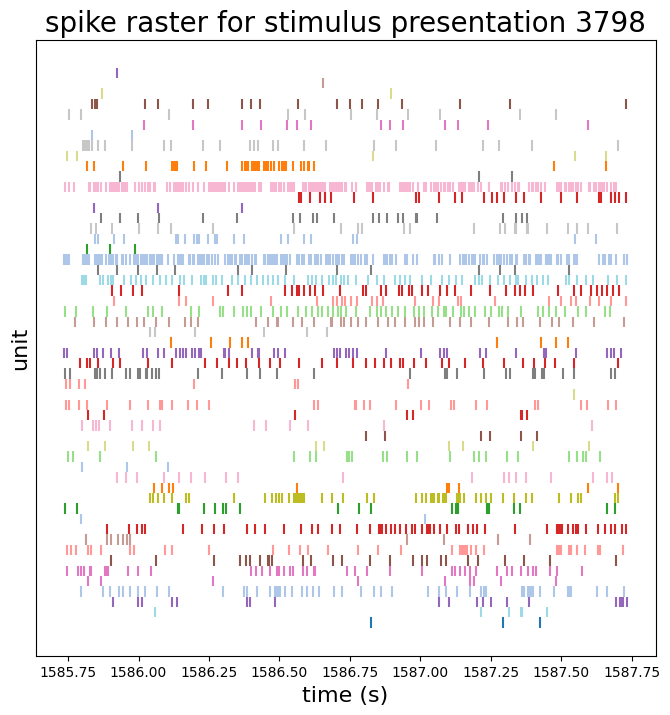

<Figure size 640x480 with 0 Axes>

In [44]:
print(plot_times['unit_id'].unique().shape)
fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')
plt.show()
plt.savefig(f'./plots/raster_{first_drifting_grating_presentation_id}.png')

In [45]:
times.to_csv('../data/processed/quality_spike_times_drifting_gratings.csv')

In [161]:
with open('../data/processed/spike_train_trials_drifting_gratings.pkl','wb') as f:
    pkl.dump(spike_train_trials,f)

# GPFA on Spike Trains

In [7]:
with open('../data/processed/spike_train_trials_drifting_gratings.pkl','rb') as f:
    spike_train_trials = pkl.load(f)

In [8]:
spike_train_trials

[([SpikeTrain containing 104 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1588.7368909550662 s,
   SpikeTrain containing 30 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1588.7368909550662 s,
   SpikeTrain containing 46 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1588.7368909550662 s,
   SpikeTrain containing 20 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1588.7368909550662 s,
   SpikeTrain containing 87 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1588.7368909550662 s,
   SpikeTrain containing 2 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1588.7368909550662 s,
   SpikeTrain containing 0 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1588.7368909550662 s,
   SpikeTrain containing 0 spikes; units s; datatype float64 
   time: 1585.7344179863614 s to 1588.7368909550662 s,
   SpikeTrain containing 4 spikes; units s; datatype float

In [10]:
with warnings.catch_warnings(action='ignore'):
    # We will select best x_dim based on log likelihood
    x_dims = range(1,41)
    log_likelihoods = []
    for x_dim in tqdm(x_dims, desc='Testing best dimensions n for GPFA'):
        gpfa_cv = GPFA(bin_size=20*pq.ms, x_dim=x_dim)
        # estimate the log-likelihood for the given dimensionality as the mean of the log-likelihoods from 3 cross-vailidation folds
        cv_log_likelihoods = cross_val_score(gpfa_cv, [trial for (trial,_) in spike_train_trials], cv=3, n_jobs=3, verbose=True)
        log_likelihoods.append(np.mean(cv_log_likelihoods))

Testing best dimensions n for GPFA:   0%|          | 0/40 [00:00<?, ?it/s][Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 460 EM iterations.)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.4s finished
Testing best dimensions n for GPFA:   2%|▎         | 1/40 [00:09<06:05,  9.37s/it][Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.4s finished
Testing best dimensions n for GPFA:   5%|▌         | 2/40 [00:20<06:41, 10.56s/it][Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.8s finished
Testing best dimensions n for GPFA:   8%|▊         | 3/40 [00:34<07:25, 12.04s/it][Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   17.5s finished
Testing best dimensions n for GPFA:  10%|█         | 4/40 [00:52<08:31, 14.21s/it][Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


Testing best dimensions n for GPFA:  10%|█         | 4/40 [01:05<09:51, 16.43s/it]


KeyboardInterrupt: 

NameError: name 'x_dims' is not defined

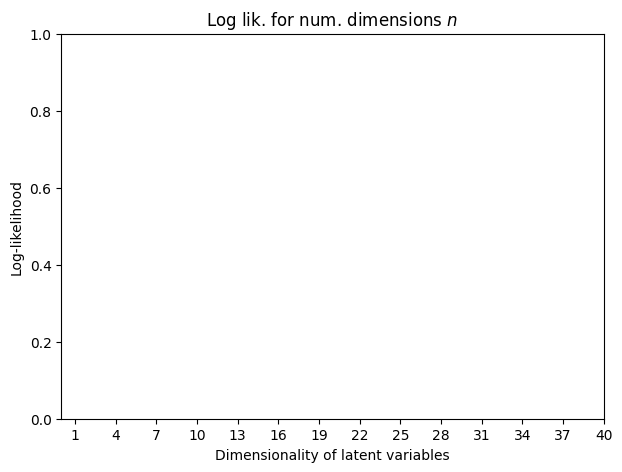

In [ ]:
f = plt.figure(figsize=(7, 5))
plt.title('Log lik. for num. dimensions $n$')
plt.xlabel('Dimensionality of latent variables')
plt.ylabel('Log-likelihood')
plt.xticks(np.arange(1,41,3))
plt.plot(x_dims, log_likelihoods, '.-')
plt.plot(x_dims[np.argmax(log_likelihoods)], np.max(log_likelihoods), 'x', markersize=10, color='r',label='Highest Log Lik.')
plt.plot(15, log_likelihoods[14],'o',markersize=10,color='g',label='Elbow')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
gpfa_best_dim = GPFA(bin_size=20*pq.ms, x_dim=9)


In [47]:
gpfa_spike_train_trials = gpfa_best_dim.fit_transform(spiketrains=[trial for (trial,_) in spike_train_trials])

Initializing parameters using factor analysis...

Fitting GPFA model...


In [26]:
gpfa_single_trial = gpfa_best_dim.fit_transform(spiketrains=[all_spikes])

Initializing parameters using factor analysis...

Fitting GPFA model...


: 

In [ ]:
for i in range(100): assert gpfa_spike_train_trials[i].shape[1]==150

In [71]:
trial_buckets = [buckets for (_,buckets) in spike_train_trials]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

times_buckets = [
    times.loc[
            np.vectorize(lambda n: find_nearest(times.index.values, n))(buckets)
    ] for buckets in trial_buckets
]


array([1585.75, 1585.77, 1585.79, 1585.81, 1585.83, 1585.85, 1585.87,
       1585.89, 1585.91, 1585.93, 1585.95, 1585.97, 1585.99, 1586.01,
       1586.03, 1586.05, 1586.07, 1586.09, 1586.11, 1586.13, 1586.15,
       1586.17, 1586.19, 1586.21, 1586.23, 1586.25, 1586.27, 1586.29,
       1586.31, 1586.33, 1586.35, 1586.37, 1586.39, 1586.41, 1586.43,
       1586.45, 1586.47, 1586.49, 1586.51, 1586.53, 1586.55, 1586.57,
       1586.59, 1586.61, 1586.63, 1586.65, 1586.67, 1586.69, 1586.71,
       1586.73, 1586.75, 1586.77, 1586.79, 1586.81, 1586.83, 1586.85,
       1586.87, 1586.89, 1586.91, 1586.93, 1586.95, 1586.97, 1586.99,
       1587.01, 1587.03, 1587.05, 1587.07, 1587.09, 1587.11, 1587.13,
       1587.15, 1587.17, 1587.19, 1587.21, 1587.23, 1587.25, 1587.27,
       1587.29, 1587.31, 1587.33, 1587.35, 1587.37, 1587.39, 1587.41,
       1587.43, 1587.45, 1587.47, 1587.49, 1587.51, 1587.53, 1587.55,
       1587.57, 1587.59, 1587.61, 1587.63, 1587.65, 1587.67, 1587.69,
       1587.71, 1587

In [76]:
for bucket in trial_buckets: assert bucket.shape[0]==150

In [77]:

speed_buckets = [
    times_bucket.groupby(times_bucket.index).first()['speed'] for times_bucket in times_buckets
]

In [119]:
traj_and_speed_data = {'trajectories':gpfa_spike_train_trials,'speeds':speed_buckets}
traj_and_speed_data

{'trajectories': array([array([[-0.60068008, -0.62721364, -0.67928904, ...,  0.38651546,
                 0.39669032,  0.39448151],
               [ 0.44690887,  0.44112245,  0.43433646, ...,  0.21116188,
                 0.18511313,  0.1586422 ],
               [-0.00862624, -0.0192221 , -0.04257493, ...,  0.44589549,
                 0.42599006,  0.39955673],
               ...,
               [-0.27192731, -0.26496929, -0.25200721, ...,  0.05034583,
                 0.04939571,  0.05040213],
               [ 0.00780287,  0.00973829,  0.01063619, ..., -0.054799  ,
                -0.05825779, -0.06143447],
               [-0.03342575, -0.0382289 , -0.04299357, ...,  0.01029844,
                 0.00769267,  0.00508958]])                             ,
        array([[-0.8772916 , -0.90899633, -0.94843341, ..., -0.03710742,
                -0.05029989, -0.07061371],
               [ 0.27783538,  0.26187679,  0.24360574, ...,  0.25149164,
                 0.23681629,  0.22259226],
     

In [120]:
traj_and_speed_data['speeds'][0]

spike_time
1585.750325     1.376282
1585.770028     1.376282
1585.790288     1.041328
1585.809054     2.245632
1585.830128     1.154294
                 ...    
1587.689726    12.905869
1587.710127    15.156117
1587.729126    13.832394
1587.733711    13.832394
1588.737530    14.781210
Name: speed, Length: 102, dtype: float64

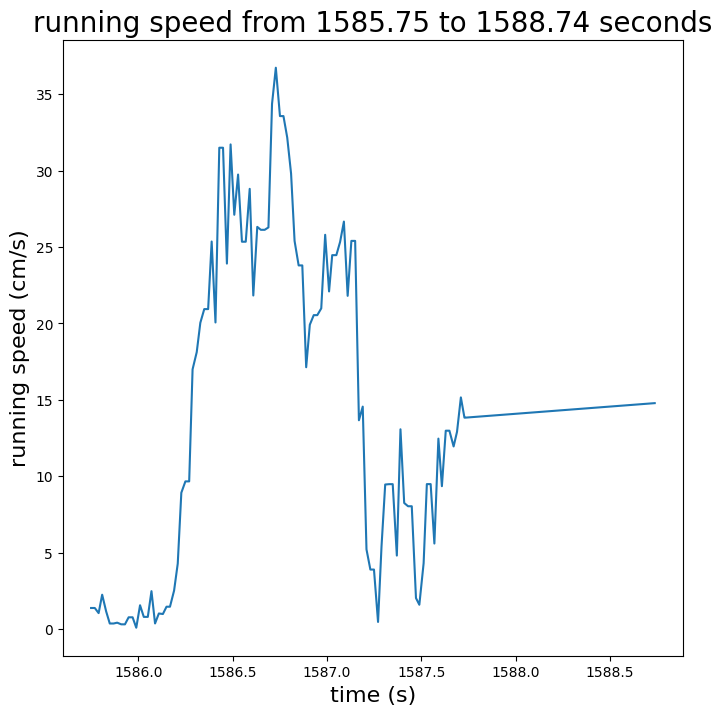

In [121]:
_=plot_running_speed(values=traj_and_speed_data['speeds'][0].values, timestamps=traj_and_speed_data['speeds'][0].index.values)
plt.savefig(f'./plots/speeds_{first_drifting_grating_presentation_id}.png')

In [124]:
import pickle as pkl

assert gpfa_spike_train_trials is not None

with open('../data/gpfa_spike_data.pkl','wb') as f:
    pkl.dump(gpfa_spike_train_trials,f)


In [125]:
assert traj_and_speed_data

with open('../data/traj_and_speed_data.pkl','wb') as f:
    pkl.dump(traj_and_speed_data,f)

In [3]:
with open('../data/gpfa_spike_data.pkl','rb') as f:
    gpfa_spike_train_trials = pkl.load(f)

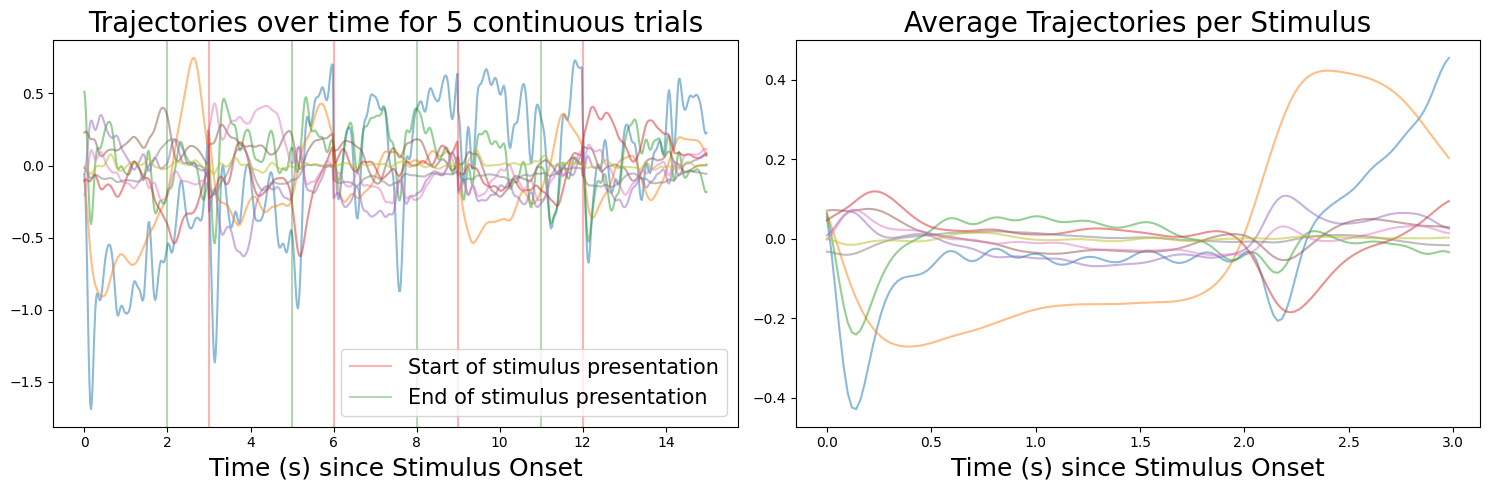

In [14]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))

for traj in [np.concatenate([gpfa_spike_train_trials[11+m][n]for m in range(5)]) for n in range(9)]:
    ax1.plot(np.arange(0,15,0.02), traj, alpha=0.5)
for n in range(3,15,3):
    l1=ax1.axvline(n,color='r',alpha=0.3,label='Start of stimulus presentation')
    l2=ax1.axvline(n-1, color='g',alpha=0.3,label='End of stimulus presentation')
ax1.set_title('Trajectories over time for 5 continuous trials',fontsize=20)
ax1.set_xlabel('Time (s) since Stimulus Onset',fontsize=18)
ax1.legend(handles=[l1,l2],fontsize=17)

for traj in gpfa_spike_train_trials.mean():
    ax2.plot(np.arange(0,3,0.02), traj, alpha=0.5)
ax2.set_title('Average Trajectories per Stimulus',fontsize=20)
ax2.set_xlabel('Time (s) since Stimulus Onset',fontsize=18)

plt.tight_layout()
plt.savefig('trajectories_extracted.png')

In [190]:
[np.concatenate([gpfa_spike_train_trials[11][n],gpfa_spike_train_trials[12][n]]) for n in range(9)]

[array([-6.38461758e-02, -1.76727966e-01, -3.78544973e-01, -6.50777137e-01,
        -9.62463077e-01, -1.26374275e+00, -1.50641836e+00, -1.65430186e+00,
        -1.68901045e+00, -1.62861633e+00, -1.48822538e+00, -1.31465776e+00,
        -1.14342386e+00, -1.00900002e+00, -9.22584927e-01, -8.87600772e-01,
        -8.90140205e-01, -9.13287370e-01, -9.31553232e-01, -9.33975564e-01,
        -9.13385852e-01, -8.73709324e-01, -8.21657196e-01, -7.60265245e-01,
        -7.04112784e-01, -6.53033461e-01, -6.14793444e-01, -5.84557196e-01,
        -5.61872400e-01, -5.49863289e-01, -5.48028330e-01, -5.53947301e-01,
        -5.76263744e-01, -6.11981169e-01, -6.59109543e-01, -7.25144724e-01,
        -8.03288533e-01, -8.83986423e-01, -9.58466917e-01, -1.01223718e+00,
        -1.04087928e+00, -1.03721912e+00, -1.01758205e+00, -9.91750102e-01,
        -9.74650849e-01, -9.71297601e-01, -9.79276743e-01, -9.95655990e-01,
        -1.01213725e+00, -1.02023889e+00, -1.02544063e+00, -1.02700862e+00,
        -1.0

In [ ]:
gp